# Imports

In [40]:
# Basics
import pandas as pd # for data loading and manipulation
import matplotlib.pyplot as plt # for visualizations

# TensorFlow
import tensorflow as tf       # Core TensorFlow library
from tensorflow import keras  # Keras API for model building
from keras import layers      # Keras layers like Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint  # import necessary callback classes

In [29]:
#pip install tensorflow-addons

# Load Preprocessed Data

Before we can train a model, we need to load the preprocessed data that we cleaned, split, and scaled. This step ensures we’re working with the correct inputs and that everything is shaped properly for modeling.

In [30]:
# Load the scaled training features from CSV
X_train = pd.read_csv('X_train_scaled.csv')  # Feature matrix for training

# Load the scaled validation features from CSV
X_val = pd.read_csv('X_val_scaled.csv')      # Feature matrix for validation

# Load the training target labels from CSV
y_train = pd.read_csv('y_train.csv')         # Target labels for training

# Load the validation target labels from CSV
y_val = pd.read_csv('y_val.csv')             # Target labels for validation

# Flatten the target arrays to 1D (required for modeling)
y_train = y_train.values.ravel()                  # Convert to 1D array
y_val = y_val.values.ravel()                      # Convert to 1D array

Now let’s confirm that the data was loaded correctly and that the shapes match expectations.

In [31]:
# Check Shape
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (80000, 20)
X_val shape: (20000, 20)
y_train shape: (80000,)
y_val shape: (20000,)


And to check the class balance

In [32]:
# Check class balance
y_train_series = pd.Series(y_train)
y_val_series = pd.Series(y_val)

print("\nTraining set class balance (%):")
train_pct = y_train_series.value_counts(normalize=True) * 100
for label, pct in train_pct.items():
    print(f"{label} {pct:.2f}%")

print("\nValidation set class balance (%):")
val_pct = y_val_series.value_counts(normalize=True) * 100
for label, pct in val_pct.items():
    print(f"{label} {pct:.2f}%")


Training set class balance (%):
0 71.00%
1 29.00%

Validation set class balance (%):
0 71.00%
1 29.00%


We’ve successfully loaded and inspected the training and validation datasets. The shapes of the feature and label arrays are exactly what we expected, and the class balance in both splits mirrors the original distribution — 71% for class 0 and 29% for class 1. That confirms our preprocessing and saving steps worked as intended, and we’re starting off with clean, well-structured data. Ready to move on to building the model!

# Initial Neural Network Model

Now that our data is clean and aligned, let’s define, compile, and prepare the neural network for binary classification of credit risk

## Define the Model

Our features live in a pandas DataFrame X_train. We extract the column count so the network knows how many inputs to expect.

In [33]:
# Count columns (features) in the training DataFrame
num_features = X_train.shape[1]         # shape: (rows, cols); index 1 is cols
print(f"Number of features: {num_features}")  # confirm we pulled the right value

Number of features: 20


Here we stack two Dense layers with ReLU activations, each followed by Dropout to reduce overfitting. For binary credit-risk prediction, we use an otput layer with a single neuron with a sigmoid activation to output a probability.

In [34]:
# Build the Sequential model with an explicit Input layer
model = keras.Sequential([  
    # clear input specification
    keras.Input(shape=(num_features,)), 
    # first hidden layer
    layers.Dense(64, activation='relu'),  
    # 30% dropout for regularization
    layers.Dropout(0.3),
    # second hidden layer
    layers.Dense(32, activation='relu'),
    # another dropout block
    layers.Dropout(0.3),    
    # output layer
    layers.Dense(1, activation='sigmoid')    
])

# Inspect the architecture
model.summary()   # print layer shapes and parameter counts

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the Model

In this step, we'll
- Compile the model to define its learning behavior
- Set up callbacks for early stopping and checkpoints
- Train the model on the data and capture its learning history

We specify the optimizer, loss function, and evaluation metrics that guide weight updates during training.
- Adam optimizer adapts the learning rate for each parameter by combining momentum and RMSProp, which accelerates convergence. It uses bias-corrected moving averages of gradients and squared gradients for stable updates. This optimizer generally works well out of the box with minimal tuning.
- Binary crossentropy computes the divergence between true labels and predicted probabilities, directly optimizing the log-likelihood of the correct class. It heavily penalizes confident but incorrect predictions, leading to better-calibrated outputs. Its smooth gradients help ensure stable training dynamics.
- Accuracy calculates the proportion of correct predictions over all samples, offering an intuitive measure of overall performance. It serves as a quick sanity check to confirm the model is learning. However, it can mask poor performance on minority classes when data is imbalanced.
- Precision measures the fraction of positive predictions that are actually correct. It’s crucial when false positives carry high costs, such as mislabeling low-risk customers as defaulters. A high precision ensures our “will default” alerts are trustworthy. Basically, of all borrowers flagged as “likely to default,” what fraction actually defaults? Controls the cost of false alarms.
- Recall quantifies the fraction of actual positives detected by the model. It’s vital when missing positive cases is costly, like failing to flag a genuine defaulter. Maximizing recall ensures comprehensive coverage of the risk pool. So, of all actual defaulters, what fraction did we catch? Crucial for minimizing missed high-risk customers (false negatives).
- ROC AUC summarizes the trade-off between true positive rate and false positive rate across all thresholds. It provides a threshold-agnostic measure of the model’s ability to rank positive instances higher than negative ones. Values closer to 1 indicate strong discriminative power. In other wowrds, it measures how well the model separates defaulters from non-defaulters across every possible threshold. Good for general model comparison.

In [35]:
# Compile the model with training settings
model.compile(
    optimizer='adam',                        # adaptive learning rate optimizer
    loss='binary_crossentropy',              # loss suited for two-class problems
    metrics=[
        'accuracy',                          # overall accuracy
        tf.keras.metrics.AUC(name='auc'),    # ROC AUC to track ranking power
        tf.keras.metrics.Precision(name='precision'),  # precision metric
        tf.keras.metrics.Recall(name='recall')         # recall metric
    ]
)

Now we'll configure our callbacks:
- early_stop: Halt training when validation loss stops improving (prevents overfitting)
- checkpoint: Save the model weights at the epoch with the best validation metric.

Here, we'll use AUC for our metric. AUC is generally a solid choice for a checkpoint because it captures the model’s ability to rank defaulters vs. non-defaulters across every possible threshold, it’s robust to class imbalance and doesn’t force us into a single cutoff.  
- If your priority is catching as many defaulters as possible (even at the expense of more false alarms), we could instead monitor recall. That will stop training once you’ve maximized our coverage of true defaulters.  
- On the other hand, if false positives (wrongly flagging safe customers) are especially costly, precision is a better single-metric guide: it ensures that the positives we do predict are trustworthy.  
- Accuracy is the least advisable here. On imbalanced credit-risk data it can look deceptively high even while we’re missing most defaulters.

In [36]:
# EarlyStopping halts training when validation AUC stops improving
early_stop = EarlyStopping(
    monitor='val_auc',            # metric to watch on validation data
    patience=5,                   # how many epochs with no improvement before stopping
    mode='max',                   # we want to maximize AUC
    restore_best_weights=True     # after stopping, load the weights from the best epoch
)

# ModelCheckpoint saves model weights whenever validation AUC improves
checkpoint = ModelCheckpoint(
    filepath='best_credit_model.keras',  # file path to save the best model
    monitor='val_auc',                # metric to watch on validation data
    mode='max',                       # we consider higher AUC “better”
    save_best_only=True               # only keep the checkpoint with the highest val_auc
)

# Loading back later
#from tensorflow.keras.models import load_model
#model = load_model('best_credit_model.keras')

Now we'll train our model by fitting it on the data.

In [37]:
history = model.fit(                        # launch training and store per-epoch logs
    X_train,                                # input features for training (customer data)
    y_train,                                # binary targets for training (0 or 1 default labels)
    validation_data=(X_val, y_val),         # features/labels to validate after each epoch
    epochs=50,                              # maximum epochs (full passes through train set)
    batch_size=32,                          # samples per gradient update
    callbacks=[early_stop, checkpoint]      # early stopping & best-model checkpointing
)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 737us/step - accuracy: 0.7590 - auc: 0.7678 - loss: 0.5138 - precision: 0.6150 - recall: 0.4636 - val_accuracy: 0.7977 - val_auc: 0.8217 - val_loss: 0.4528 - val_precision: 0.7095 - val_recall: 0.5124
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 651us/step - accuracy: 0.7940 - auc: 0.8172 - loss: 0.4617 - precision: 0.6846 - recall: 0.5385 - val_accuracy: 0.8043 - val_auc: 0.8288 - val_loss: 0.4437 - val_precision: 0.7158 - val_recall: 0.5390
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 643us/step - accuracy: 0.8000 - auc: 0.8231 - loss: 0.4534 - precision: 0.6993 - recall: 0.5520 - val_accuracy: 0.8049 - val_auc: 0.8306 - val_loss: 0.4414 - val_precision: 0.7130 - val_recall: 0.5479
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 636us/step - accuracy: 0.8021 - auc: 0.8262 - loss: 0.4487 - precision: 0.6985 - recall: 0.5665 - val_accuracy: 0.8071 - val_auc: 0.8319 - val_loss: 0.4376 - val_precision: 0.7044 - val_recall: 0.5769
Epoch 5/50
2500/

## Visualize Training History

After training, plotting each metric over epochs allow us to not only verify convergence but also fairness and robustness.

In [38]:
print(history.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


Before plotting, we’ll turn the training history into a table. This makes slicing each metric straightforward and works seamlessly with Matplotlib.

In [39]:
# history.history is a dict: keys are metric names, values are lists over epochs
df_history = pd.DataFrame(history.history)            # convert dict to DataFrame (columns: 'loss', 'accuracy', etc.)

print(df_history.head())  # print first 5 rows to confirm correct structure

   accuracy       auc      loss  precision    recall  val_accuracy   val_auc  \
0  0.778350  0.795775  0.486269   0.657867  0.490947       0.79775  0.821713   
1  0.796838  0.819801  0.458045   0.688980  0.545737       0.80425  0.828772   
2  0.801612  0.825858  0.449126   0.696677  0.559402       0.80495  0.830621   
3  0.804563  0.828276  0.445012   0.700834  0.568842       0.80710  0.831852   
4  0.804800  0.829408  0.442564   0.702014  0.567894       0.80695  0.833263   

   val_loss  val_precision  val_recall  
0  0.452795       0.709477    0.512414  
1  0.443680       0.715823    0.538966  
2  0.441384       0.713036    0.547931  
3  0.437583       0.704421    0.576897  
4  0.437053       0.711450    0.562414  


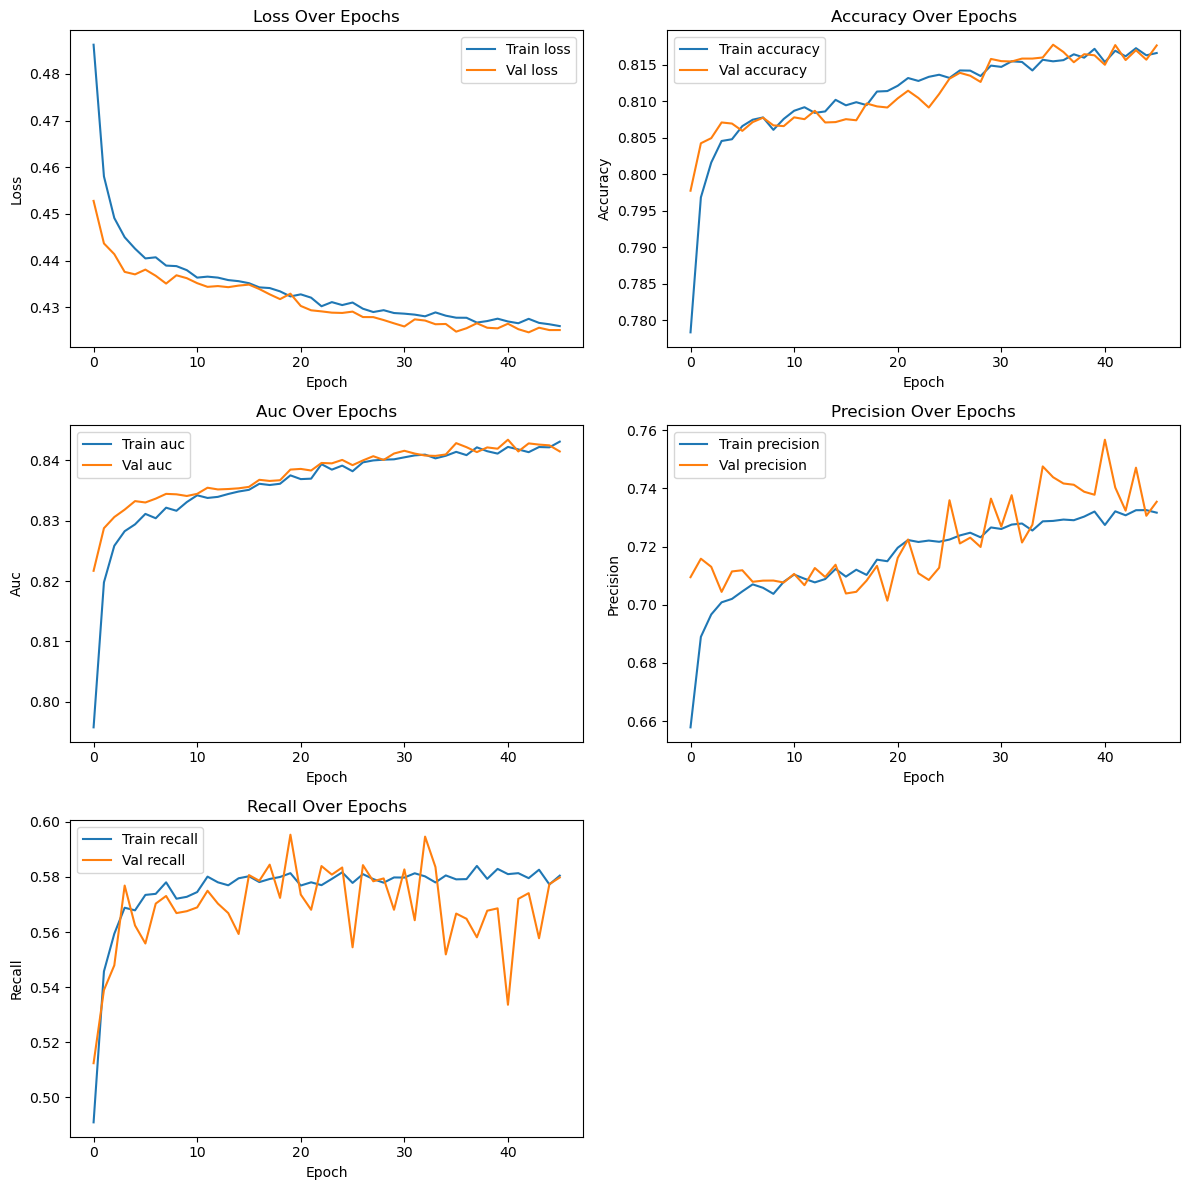

In [41]:
# Choose which metrics to visualize based on your compile() configuration
metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall']

# Determine subplot grid size: 2 columns, enough rows to fit all metrics
n_metrics = len(metrics)                             # total number of metrics to plot
n_cols = 2                                           # number of columns in the figure
n_rows = (n_metrics + n_cols - 1) // n_cols           # compute required rows (ceiling division)

plt.figure(figsize=(12, 4 * n_rows))                 # set overall figure size (width x height)

# Loop through each metric and plot its training & validation curves
for idx, metric in enumerate(metrics, start=1):
    plt.subplot(n_rows, n_cols, idx)                 # select position of the subplot
    plt.plot(df_history[metric],                     # plot training metric values
             label=f'Train {metric}')                # label for the training curve
    plt.plot(df_history[f'val_{metric}'],            # plot validation metric values
             label=f'Val {metric}')                  # label for the validation curve
    plt.title(f'{metric.capitalize()} Over Epochs')  # title reflecting the metric
    plt.xlabel('Epoch')                              # x-axis label
    plt.ylabel(metric.capitalize())                  # y-axis label
    plt.legend()                                     # add legend to distinguish curves

plt.tight_layout()                                   # adjust subplot spacing to prevent overlap
plt.show()                                           # display all subplots

Loss over epochs:
- Both training and validation loss decrease steadily from ~0.48 to ~0.43.
- Curves remain closely aligned, indicating minimal overfitting so far
- The plateau after ~30 epochs suggests diminishing returns—this is a good point for early stopping.
- A lower validation loss implies our model is improving its ability to distinguish “good” vs. “bad” without memorizing noise.

Accuracy:
- Training and validation accuracy climb in lockstep from ~0.78 to ~0.81.
- No sudden divergence. Our model generalizes well on balanced prediction counts.
- While accuracy is rising, remember that approving 81% of all cases doesn’t distinguish between class imbalances (default vs. non-default).

AUC:
- AUC improves from ~0.80 to ~0.84 on both sets.
- Parallel curves confirm your model is consistently ranking risk correctly for new applicants.
- AUC is crucial in credit scoring. An AUC of 0.84 suggests good separation between good and bad loans.

Precision:
- Precision grows from ~0.66 (train) / 0.68 (val) up to ~0.72 / 0.74.
- Validation precision slightly outperforms training
- Higher precision means fewer false positives (risky applicants mistakenly approved). In lending, this reduces potential losses.

Recall:
- Recall trends upward (train: ~0.52→0.58; val: ~0.54→0.56) but with more fluctuation
- The gap between precision and recall indicates a trade-off: you’re approving fewer risky applicants (good), but also missing some safe ones (rejecting good credit applications).
- Boosting recall means catching more good applicants—but at the cost of approving a few more bad ones. Balancing precision vs. recall aligns with your risk tolerance.